In [1]:
!pip install pandas scikit-learn matplotlib tqdm --quiet

In [2]:
!pip install bayesian-optimization

In [3]:
!pip install optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.6 MB/s eta 0:00:00


In [4]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.0.5
    Uninstalling xgboost-3.0.5:
      Successfully uninstalled xgboost-3.0.5


# Predicción de Regalías por Artista con XGBoost
### Tesis de Maestría en Ciencia de Datos
Este notebook aplica un modelo XGBoost multivariado para predecir las regalías mensuales por artista.
Se evalúa el desempeño mediante métricas de error y se exportan las predicciones para su uso en Power BI.

In [5]:
import pandas as pd

file_id = '1h97krjdPVuKszy9NVcZiWNQuPUu3ICyc' #version con artist_id
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)
df['fecha'] = pd.to_datetime(df['fecha'], format='%m/%d/%Y')
df.head()

,artist_id,fecha,royalties,instagram_followers,twitter_followers,track_release,sentiment,seguidores_menciones,cant_posteos,cant_comentarios,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_seguidores_menciones_3m,month
0,A01,2022-08-01,9181.530,6157095,2725818,0,0.000000,0,0,0,9181.530000,0.0000,0,0,0,0.000000,0,8
1,A01,2022-09-01,11326.315,6267740,2724330,0,0.000000,0,2,40,10253.922500,78237.8298,-1488,110645,0,0.000000,0,9
2,A01,2022-10-01,8111.670,6387042,2721716,0,0.555556,0,1,27,9539.838333,115000.6565,-2614,119302,0,0.185185,0,10
3,A01,2022-11-01,8916.570,6460584,2718405,1,0.610169,0,3,118,9384.021250,133558.2623,-3311,73542,1,0.388575,0,11
4,A01,2022-12-01,12755.920,6562667,2713392,1,0.538462,0,1,39,10058.401000,159183.7579,-5013,102083,2,0.568062,0,12


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


# ================================================================
# ⚙️ CONFIGURACIÓN GLOBAL
# ================================================================
pbounds = {
    "max_depth": (3, 10),
    "learning_rate": (0.01, 0.3),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "n_estimators": (50, 1000)
}

features = [
    "instagram_followers", "twitter_followers", "track_release", "sentiment",
    "seguidores_menciones", "cant_posteos", "cant_comentarios",
    "mean_royalties_6m", "std_instagram_followers_6m",
    "growth_twitter_followers", "growth_instagram_followers",
    "sum_track_releases_6m", "mean_sentiment_3m",
    "sum_seguidores_menciones_3m", "month"
]

resultados_xgb = []

# ================================================================
# 🧩 FUNCIÓN: Walk Forward Validation (1 año train → 6 meses test)
# ================================================================

def walk_forward_validation(X, y, model_params, artist_id=None, initial_train_size=18, step=6, verbose=True):
    preds = []
    actuals = []
    rmse_list = []
    iteration = 1

    for i in range(initial_train_size, len(X) - step + 1, step):
        X_train, y_train = X.iloc[:i], y.iloc[:i]
        X_test, y_test = X.iloc[i:i+step], y.iloc[i:i+step]

        model = XGBRegressor(
            **model_params,
            random_state=42,
            objective="reg:squarederror"
        )
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_test)

        # Calcular RMSE por ventana
        rmse_window = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse_window)
        preds.extend(y_pred)
        actuals.extend(y_test.values)

        # 🧩 Logs de depuración
        if verbose:
            fecha_train_start = y_train.index[0]
            fecha_train_end = y_train.index[-1]
            fecha_test_start = y_test.index[0]
            fecha_test_end = y_test.index[-1]
            print(f"\n🎵 Artista: {artist_id} | Iteración {iteration}")
            print(f"Train: {len(X_train)} meses ({fecha_train_start} → {fecha_train_end})")
            print(f"Test:  {len(X_test)} meses ({fecha_test_start} → {fecha_test_end})")
            print(f"RMSE ventana: {rmse_window:.4f}")

        iteration += 1

    # RMSE promedio global
    rmse_global = np.sqrt(mean_squared_error(actuals, preds))
    if verbose:
        print(f"\n✅ Artista {artist_id} | RMSE promedio walk-forward: {rmse_global:.4f}")

    return rmse_global, rmse_list


# ================================================================
# 🔁 LOOP PRINCIPAL POR ARTISTA
# ================================================================
for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("fecha")
    group["fecha"] = pd.to_datetime(group["fecha"])  # aseguramos tipo datetime
    group = group.set_index("fecha")                 # establecemos índice temporal

    X = group[features]
    y = group["royalties"]

    # Se requiere al menos 18 meses de datos (12 train + 6 test)
    if len(y) < 18:
        continue

    try:
        # Definir función objetivo para BO
        def xgb_cv(max_depth, learning_rate, subsample, colsample_bytree, n_estimators):
            params = {
                "max_depth": int(max_depth),
                "learning_rate": learning_rate,
                "subsample": subsample,
                "colsample_bytree": colsample_bytree,
                "n_estimators": int(n_estimators)
            }
            rmse, rmse_list = walk_forward_validation(X, y, params,artist_id=artist_id,initial_train_size=18,step=6,verbose=True)
            return -rmse  # BO maximiza, por eso usamos negativo

        optimizer = BayesianOptimization(
            f=xgb_cv,
            pbounds=pbounds,
            random_state=42,
            verbose=0
        )
        optimizer.maximize(init_points=5, n_iter=15)

        # Extraer mejores parámetros
        best_params = optimizer.max["params"]
        best_params["max_depth"] = int(best_params["max_depth"])
        best_params["n_estimators"] = int(best_params["n_estimators"])

        # Entrenar modelo final con todos los datos
        final_model = XGBRegressor(**best_params, random_state=42, objective="reg:squarederror")
        final_model.fit(X, y)

        # Guardar resultados
        resultados_xgb.append({
            "Artist_ID": artist_id,
            **best_params,
            "RMSE_walkfwd": -optimizer.max["target"]
        })

    except Exception as e:
        print(f"⚠️ Error en {artist_id}: {e}")
        continue


  0%|          | 0/15 [00:00<?, ?it/s]


🎵 Artista: A01 | Iteración 1
Train: 18 meses (2022-08-01 00:00:00 → 2024-01-01 00:00:00)
Test:  6 meses (2024-02-01 00:00:00 → 2024-07-01 00:00:00)
RMSE ventana: 1679.9512

🎵 Artista: A01 | Iteración 2
Train: 24 meses (2022-08-01 00:00:00 → 2024-07-01 00:00:00)
Test:  6 meses (2024-08-01 00:00:00 → 2025-01-01 00:00:00)
RMSE ventana: 969.0117

✅ Artista A01 | RMSE promedio walk-forward: 1371.3533

🎵 Artista: A01 | Iteración 1
Train: 18 meses (2022-08-01 00:00:00 → 2024-01-01 00:00:00)
Test:  6 meses (2024-02-01 00:00:00 → 2024-07-01 00:00:00)
RMSE ventana: 1519.7119

🎵 Artista: A01 | Iteración 2
Train: 24 meses (2022-08-01 00:00:00 → 2024-07-01 00:00:00)
Test:  6 meses (2024-08-01 00:00:00 → 2025-01-01 00:00:00)
RMSE ventana: 1007.7994

✅ Artista A01 | RMSE promedio walk-forward: 1289.4153

🎵 Artista: A01 | Iteración 1
Train: 18 meses (2022-08-01 00:00:00 → 2024-01-01 00:00:00)
Test:  6 meses (2024-02-01 00:00:00 → 2024-07-01 00:00:00)
RMSE ventana: 1973.2044

🎵 Artista: A01 | Iteració

In [ ]:
# ================================================================
# 📊 RESULTADOS GLOBALES
# ================================================================
df_resultados_xgb = pd.DataFrame(resultados_xgb)
print("📈 Resultados por artista:")
print(df_resultados_xgb)

mean_params = df_resultados_xgb[[
    "max_depth", "learning_rate", "subsample", "colsample_bytree", "n_estimators"
]].mean()

mode_max_depth = df_resultados_xgb["max_depth"].mode()[0]

best_params_global = {
    "max_depth": int(round(mode_max_depth)),
    "learning_rate": float(round(mean_params["learning_rate"], 3)),
    "subsample": float(round(mean_params["subsample"], 2)),
    "colsample_bytree": float(round(mean_params["colsample_bytree"], 2)),
    "n_estimators": int(round(mean_params["n_estimators"]))
}

print("\n🏆 Hiperparámetros globales sugeridos:")
print(best_params_global)


📈 Resultados por artista:
   Artist_ID  max_depth  learning_rate  subsample  colsample_bytree  \
0        A01          4       0.086820   0.688760          0.716892   
1        A02          4       0.104126   0.775733          0.695788   
2        A03          3       0.291274   0.916221          0.606170   
3        A04          6       0.010000   0.533916          0.744952   
4        A05          4       0.240172   0.805041          0.530510   
5        A06          6       0.244892   0.542652          0.737529   
6        A07          6       0.244892   0.542652          0.737529   
7        A08          9       0.112465   0.636548          0.546779   
8        A09          3       0.291274   0.916221          0.606170   
9        A10          4       0.153878   0.982893          0.844337   
10       A11          5       0.285707   0.865997          0.799329   
11       A12          6       0.244892   0.542652          0.737529   
12       A13          3       0.291274   0.916221  

# Hiperparametros Elegidos

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# ================================================================
# 🏆 Hiperparámetros globales elegidos (walk-forward final)
# ================================================================
best_params = {
    "max_depth": 5,
    "learning_rate": 0.193,
    "subsample": 0.79,
    "colsample_bytree": 0.74,
    "n_estimators": 1000,
    "random_state": 42,
    "objective": "reg:squarederror"
}

# ================================================================
# ⚙️ Variables y contenedores
# ================================================================
resultados_xgb = []
predicciones_xgb = []

features = [
    "instagram_followers", "twitter_followers", "track_release", "sentiment",
    "seguidores_menciones", "cant_posteos", "cant_comentarios",
    "mean_royalties_6m", "std_instagram_followers_6m",
    "growth_twitter_followers", "growth_instagram_followers",
    "sum_track_releases_6m", "mean_sentiment_3m",
    "sum_seguidores_menciones_3m", "month"
]

# ================================================================
# 🧩 Función Walk-Forward (18 meses train → 6 meses test)
# ================================================================
def walk_forward_xgb(X, y, fechas, model_params, artist_id, initial_train_size=18, step=6, verbose=True):
    preds, actuals, fechas_preds = [], [], []
    iteration = 1

    for i in range(initial_train_size, len(X), step):
        end = min(i + step, len(X))
        X_train, y_train = X.iloc[:i], y.iloc[:i]
        X_test, y_test = X.iloc[i:end], y.iloc[i:end]
        fechas_test = fechas.iloc[i:end]

        if len(X_test) == 0:
            continue

        model = XGBRegressor(**model_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="rmse",
            early_stopping_rounds=50,
            verbose=False
        )

        y_pred = model.predict(X_test)

        for f, real, pred in zip(fechas_test, y_test, y_pred):
            preds.append(pred)
            actuals.append(real)
            fechas_preds.append(f)

        if verbose:
            fecha_train_end = fechas.iloc[i-1]
            fecha_test_end = fechas_test.iloc[-1]
            print(f"\n🎵 Artista: {artist_id} | Iteración {iteration}")
            print(f"Train: {i} meses → Test: {len(y_test)} meses ({fecha_train_end.date()} → {fecha_test_end.date()})")
        iteration += 1

    # Calcular métricas globales del walk-forward
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actuals, preds)

    if verbose:
        print(f"✅ Artista {artist_id} | RMSE promedio walk-forward: {rmse:.4f}")

    return preds, actuals, fechas_preds, mse, mae, rmse, mape


# ================================================================
# 🔁 Loop principal por artista
# ================================================================
for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("fecha").reset_index(drop=True)
    group["fecha"] = pd.to_datetime(group["fecha"])

    if len(group) < 18:
        continue

    X = group[features]
    y = group["royalties"]
    fechas = group["fecha"]

    try:
        preds, actuals, fechas_preds, mse, mae, rmse, mape = walk_forward_xgb(
            X, y, fechas, best_params, artist_id,
            initial_train_size=18, step=6, verbose=True
        )

        # Guardar métricas por artista
        resultados_xgb.append({
            "Artist_ID": artist_id,
            "Modelo": "XGBoost",
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })

        # Guardar predicciones para CSV
        for f, real, pred in zip(fechas_preds, actuals, preds):
            predicciones_xgb.append({
                "artist_id": artist_id,
                "fecha": f,
                "royalties_real": real,
                "royalties_pred": pred,
                "modelo": "XGBoost"
            })

    except Exception as e:
        print(f"⚠️ Error en {artist_id}: {e}")
        continue


# ================================================================
# 💾 Exportar resultados
# ================================================================
df_resultados_xgb = pd.DataFrame(resultados_xgb)
df_predicciones_xgb = pd.DataFrame(predicciones_xgb)

df_resultados_xgb.to_csv("xgboost_metrics_por_artista.csv", index=False)
df_predicciones_xgb.to_csv("xgboost_predicciones_para_powerbi.csv", index=False)

print("\n✅ CSV generados correctamente:")
print("- xgboost_metrics_por_artista.csv")
print("- xgboost_predicciones_para_powerbi.csv")
print("\n📈 Promedio global RMSE:", round(df_resultados_xgb["RMSE"].mean(), 4))


  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



🎵 Artista: A01 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-01-01 → 2024-07-01)

🎵 Artista: A01 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-07-01 → 2025-01-01)

🎵 Artista: A01 | Iteración 3
Train: 30 meses → Test: 2 meses (2025-01-01 → 2025-03-01)
✅ Artista A01 | RMSE promedio walk-forward: 850.9412

🎵 Artista: A02 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-01-01 → 2024-07-01)


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A02 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-07-01 → 2025-01-01)

🎵 Artista: A02 | Iteración 3
Train: 30 meses → Test: 2 meses (2025-01-01 → 2025-03-01)
✅ Artista A02 | RMSE promedio walk-forward: 715.4648

🎵 Artista: A03 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-02-01 → 2024-08-01)

🎵 Artista: A03 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-08-01 → 2025-02-01)


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A03 | Iteración 3
Train: 30 meses → Test: 1 meses (2025-02-01 → 2025-03-01)
✅ Artista A03 | RMSE promedio walk-forward: 75927.0153

🎵 Artista: A04 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-01-01 → 2024-07-01)

🎵 Artista: A04 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-07-01 → 2025-01-01)

🎵 Artista: A04 | Iteración 3
Train: 30 meses → Test: 2 meses (2025-01-01 → 2025-03-01)
✅ Artista A04 | RMSE promedio walk-forward: 419.3980


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A05 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-03-01 → 2023-09-01)

🎵 Artista: A05 | Iteración 2
Train: 24 meses → Test: 6 meses (2023-09-01 → 2024-03-01)

🎵 Artista: A05 | Iteración 3
Train: 30 meses → Test: 6 meses (2024-03-01 → 2024-09-01)

🎵 Artista: A05 | Iteración 4
Train: 36 meses → Test: 6 meses (2024-09-01 → 2025-03-01)
✅ Artista A05 | RMSE promedio walk-forward: 42116.8635

🎵 Artista: A06 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-12-01 → 2024-06-01)


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A06 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-06-01 → 2024-12-01)

🎵 Artista: A06 | Iteración 3
Train: 30 meses → Test: 3 meses (2024-12-01 → 2025-03-01)
✅ Artista A06 | RMSE promedio walk-forward: 17921.4703

🎵 Artista: A07 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-03-01 → 2023-09-01)

🎵 Artista: A07 | Iteración 2
Train: 24 meses → Test: 6 meses (2023-09-01 → 2024-03-01)

🎵 Artista: A07 | Iteración 3
Train: 30 meses → Test: 6 meses (2024-03-01 → 2024-09-01)


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A07 | Iteración 4
Train: 36 meses → Test: 6 meses (2024-09-01 → 2025-03-01)
✅ Artista A07 | RMSE promedio walk-forward: 77487.8781

🎵 Artista: A08 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-02-01 → 2024-08-01)

🎵 Artista: A08 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-08-01 → 2025-02-01)

🎵 Artista: A08 | Iteración 3
Train: 30 meses → Test: 1 meses (2025-02-01 → 2025-03-01)
✅ Artista A08 | RMSE promedio walk-forward: 3004.6841

🎵 Artista: A09 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-02-01 → 2024-08-01)

🎵 Artista: A09 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-08-01 → 2025-02-01)

🎵 Artista: A09 | Iteración 3
Train: 30 meses → Test: 1 meses (2025-02-01 → 2025-03-01)
✅ Artista A09 | RMSE promedio walk-forward: 1563.6620

🎵 Artista: A10 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-02-01 → 2024-08-01)

🎵 Artista: A10 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-08-01 → 2025-02-01)

🎵 Artista: A10 | Iteración 3
Train: 30 meses

/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A11 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-03-01 → 2023-09-01)

🎵 Artista: A11 | Iteración 2
Train: 24 meses → Test: 6 meses (2023-09-01 → 2024-03-01)

🎵 Artista: A11 | Iteración 3
Train: 30 meses → Test: 6 meses (2024-03-01 → 2024-09-01)

🎵 Artista: A11 | Iteración 4
Train: 36 meses → Test: 6 meses (2024-09-01 → 2025-03-01)
✅ Artista A11 | RMSE promedio walk-forward: 4283.0654

🎵 Artista: A12 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-08-01 → 2024-02-01)

🎵 Artista: A12 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-02-01 → 2024-08-01)

🎵 Artista: A12 | Iteración 3
Train: 30 meses → Test: 6 meses (2024-08-01 → 2025-02-01)

🎵 Artista: A12 | Iteración 4
Train: 36 meses → Test: 1 meses (2025-02-01 → 2025-03-01)
✅ Artista A12 | RMSE promedio walk-forward: 293.6567


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A13 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-03-01 → 2023-09-01)

🎵 Artista: A13 | Iteración 2
Train: 24 meses → Test: 6 meses (2023-09-01 → 2024-03-01)

🎵 Artista: A13 | Iteración 3
Train: 30 meses → Test: 6 meses (2024-03-01 → 2024-09-01)

🎵 Artista: A13 | Iteración 4
Train: 36 meses → Test: 6 meses (2024-09-01 → 2025-03-01)
✅ Artista A13 | RMSE promedio walk-forward: 63674.9456

🎵 Artista: A14 | Iteración 1
Train: 18 meses → Test: 6 meses (2024-02-01 → 2024-08-01)

🎵 Artista: A14 | Iteración 2
Train: 24 meses → Test: 6 meses (2024-08-01 → 2025-02-01)

🎵 Artista: A14 | Iteración 3
Train: 30 meses → Test: 1 meses (2025-02-01 → 2025-03-01)
✅ Artista A14 | RMSE promedio walk-forward: 51294.2672


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr


🎵 Artista: A15 | Iteración 1
Train: 18 meses → Test: 6 meses (2023-03-01 → 2023-09-01)

🎵 Artista: A15 | Iteración 2
Train: 24 meses → Test: 6 meses (2023-09-01 → 2024-03-01)

🎵 Artista: A15 | Iteración 3
Train: 30 meses → Test: 6 meses (2024-03-01 → 2024-09-01)

🎵 Artista: A15 | Iteración 4
Train: 36 meses → Test: 6 meses (2024-09-01 → 2025-03-01)
✅ Artista A15 | RMSE promedio walk-forward: 21242.1000

✅ CSV generados correctamente:
- xgboost_metrics_por_artista.csv
- xgboost_predicciones_para_powerbi.csv

📈 Promedio global RMSE: 24192.0949


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr

In [ ]:
print(df_resultados_xgb)

   Artist_ID   Modelo           MSE           MAE          RMSE      MAPE
0        A01  XGBoost  7.241010e+05    634.101733    850.941249  0.137721
1        A02  XGBoost  5.118899e+05    546.236620    715.464800  0.074729
2        A03  XGBoost  5.764912e+09  58446.406923  75927.015291  0.080982
3        A04  XGBoost  1.758947e+05    334.765523    419.398030  0.119154
4        A05  XGBoost  1.773830e+09  32829.643698  42116.863505  0.083540
5        A06  XGBoost  3.211791e+08  13846.055042  17921.470251  0.092681
6        A07  XGBoost  6.004371e+09  63038.704219  77487.878101  0.097769
7        A08  XGBoost  9.028126e+06   2492.916917   3004.684085  0.096149
8        A09  XGBoost  2.445039e+06   1363.188777   1563.661994  0.101673
9        A10  XGBoost  4.351445e+06   1331.411007   2086.011700  0.089133
10       A11  XGBoost  1.834465e+07   2007.684980   4283.065420  0.183913
11       A12  XGBoost  8.623428e+04    251.389994    293.656746  0.119035
12       A13  XGBoost  4.054499e+09  5

In [ ]:
print(df_predicciones_xgb)

    artist_id      fecha  royalties_real  royalties_pred   modelo
0         A01 2024-02-01        5339.530     4227.283691  XGBoost
1         A01 2024-03-01        5150.465     4227.283691  XGBoost
2         A01 2024-04-01        4649.665     5127.595703  XGBoost
3         A01 2024-05-01        5280.665     5127.595703  XGBoost
4         A01 2024-06-01        3643.850     5127.595703  XGBoost
..        ...        ...             ...             ...      ...
256       A15 2024-11-01      445589.410   454168.093750  XGBoost
257       A15 2024-12-01      408669.115   461510.250000  XGBoost
258       A15 2025-01-01      490486.500   446660.000000  XGBoost
259       A15 2025-02-01      472673.580   447332.687500  XGBoost
260       A15 2025-03-01      491530.530   459879.093750  XGBoost

[261 rows x 5 columns]


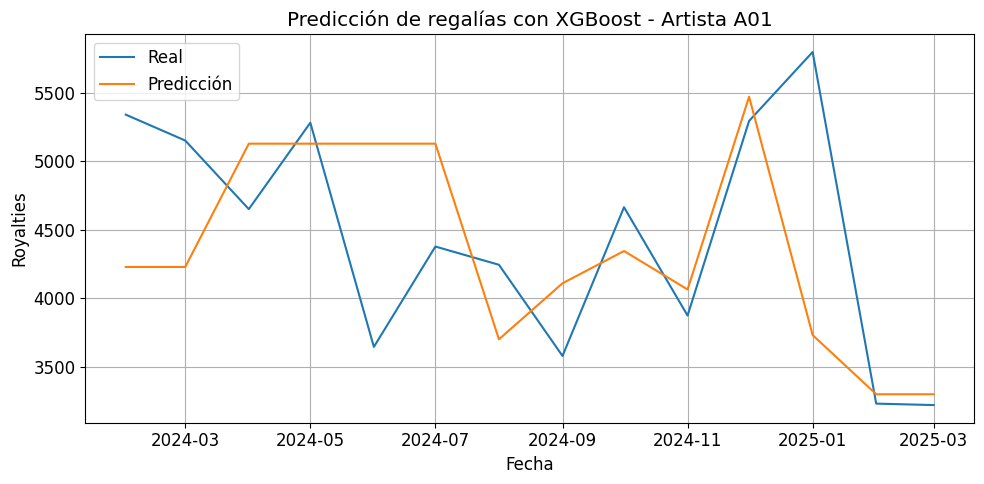

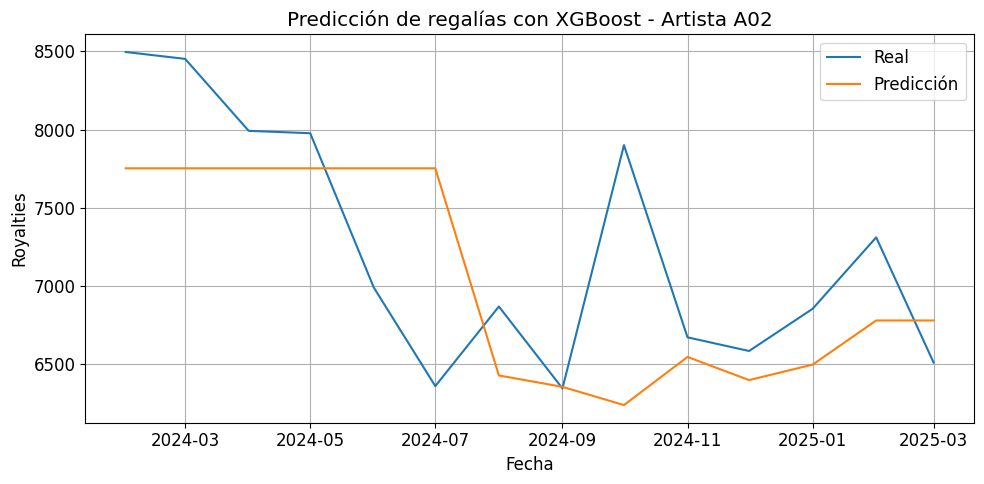

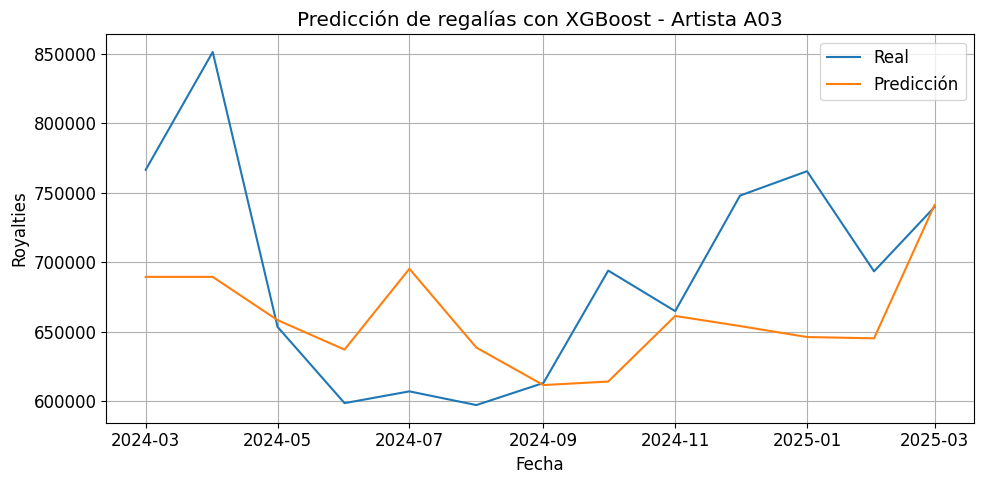

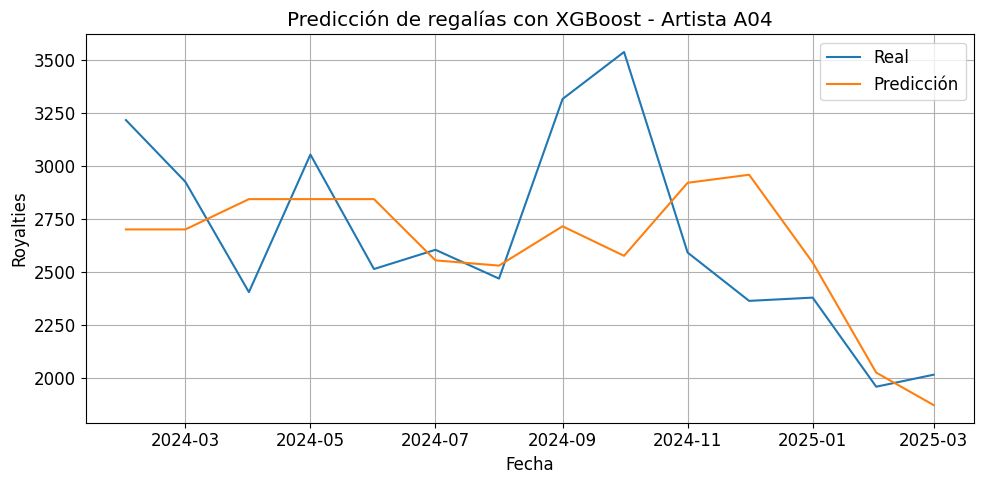

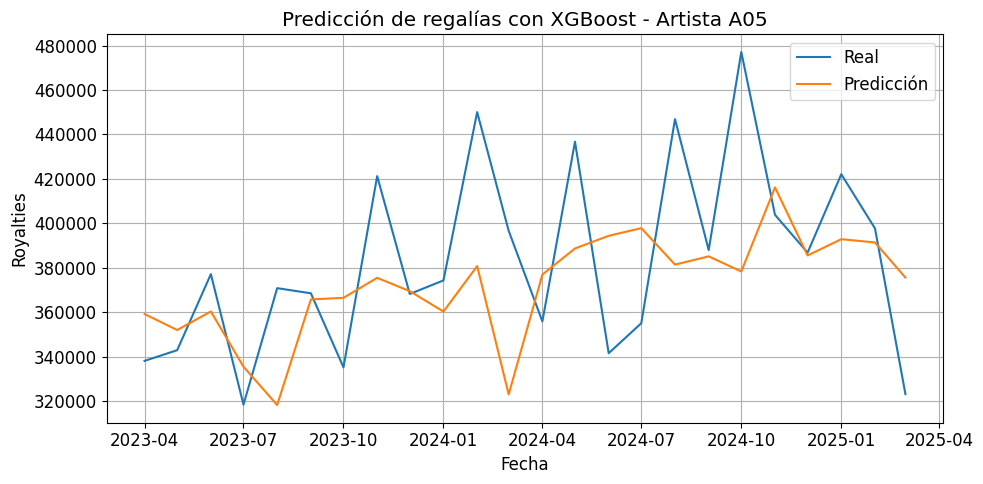

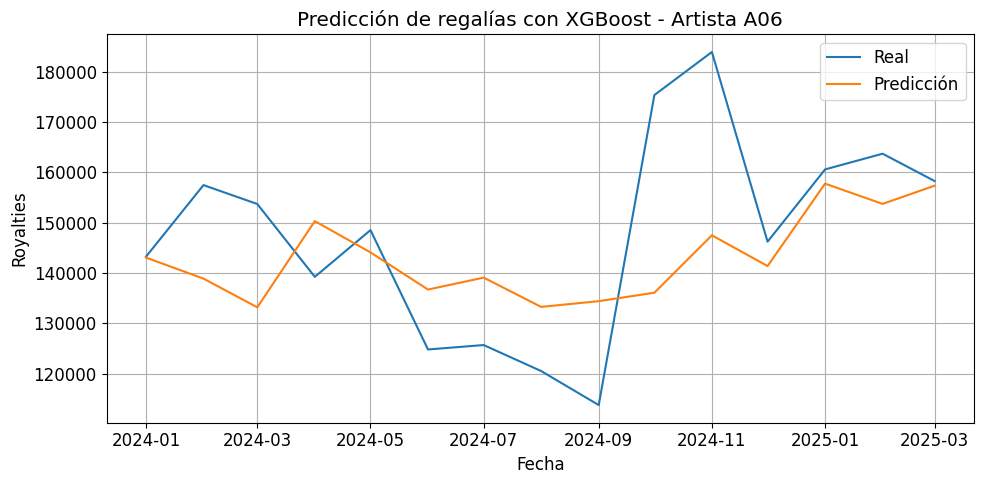

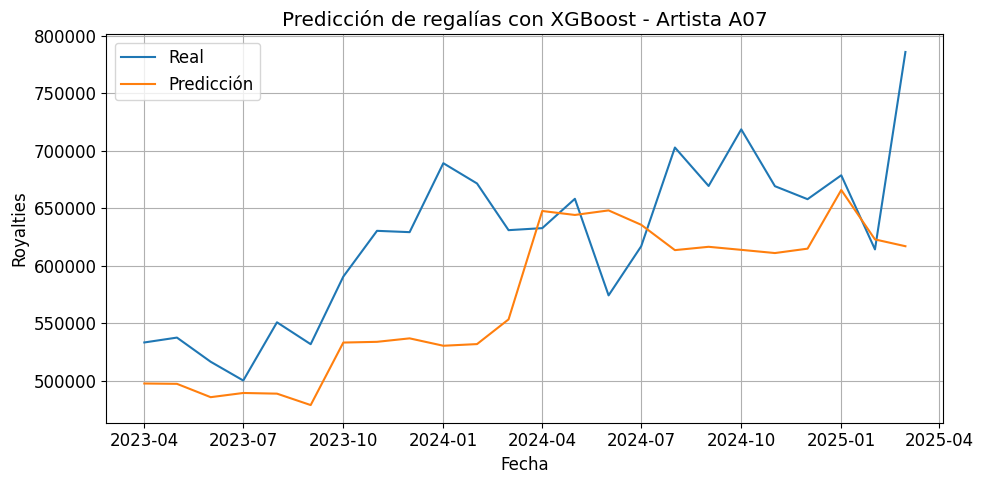

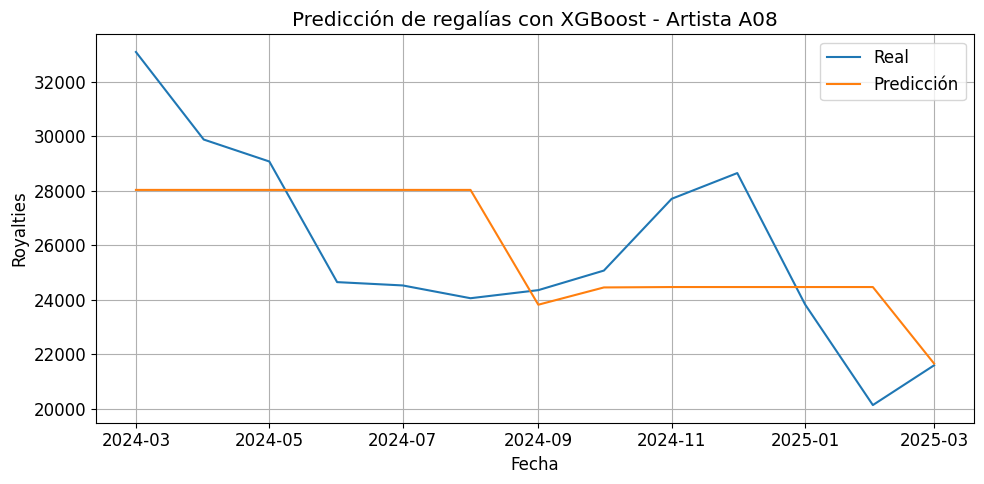

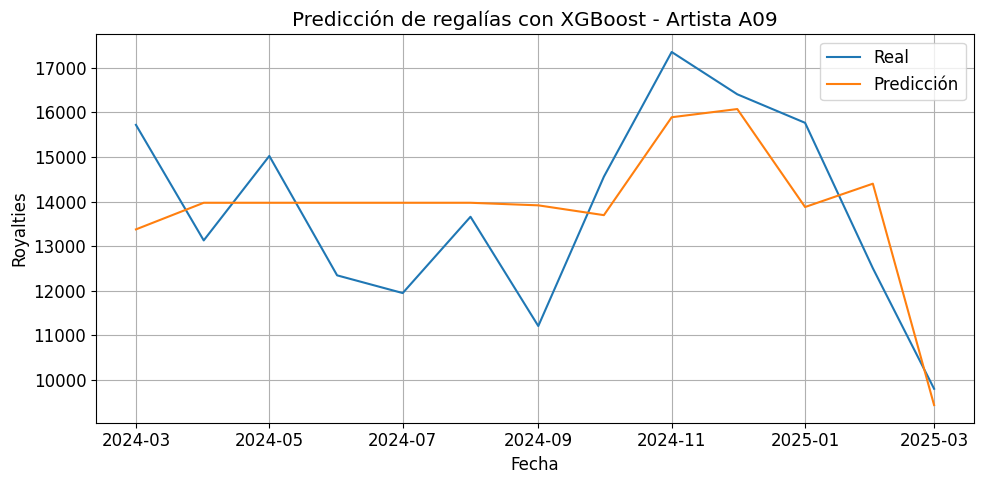

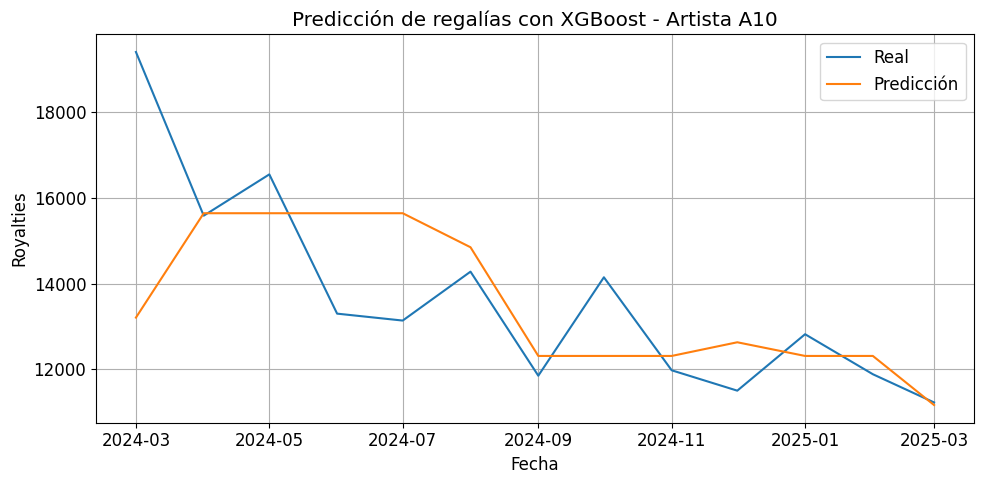

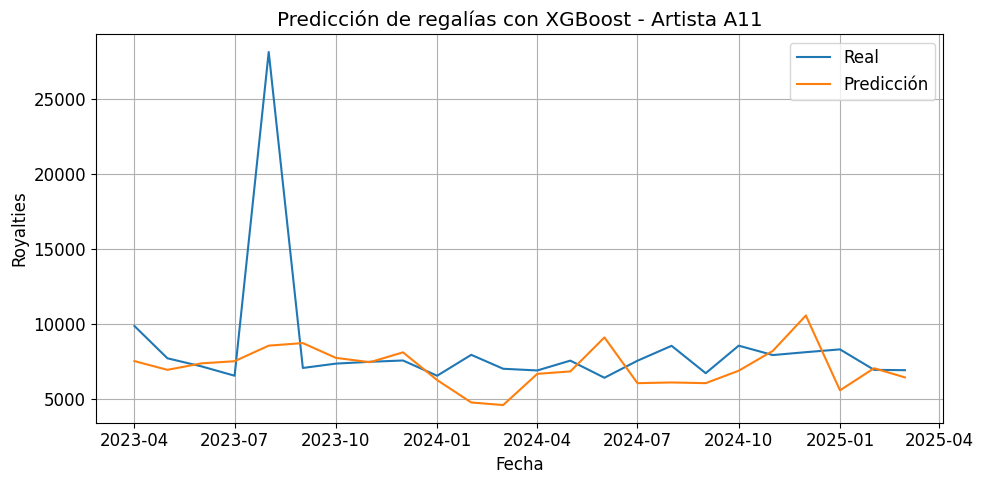

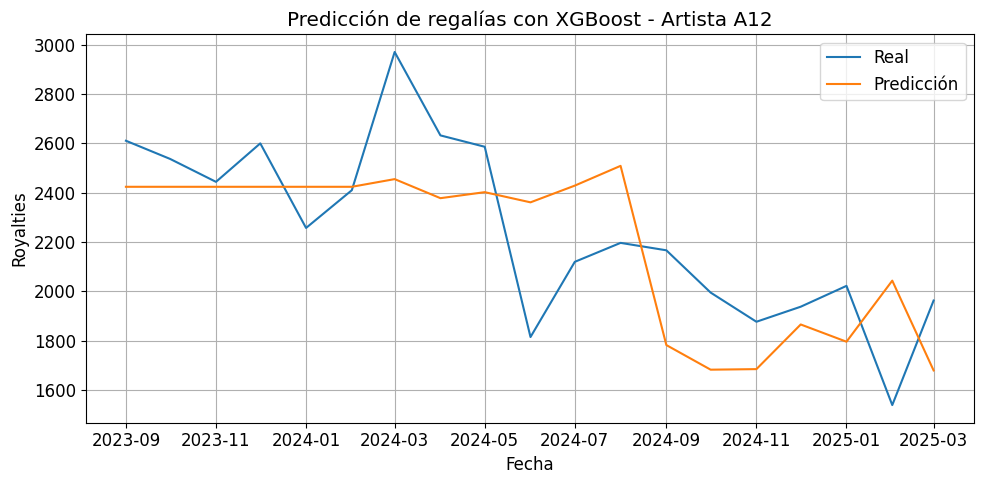

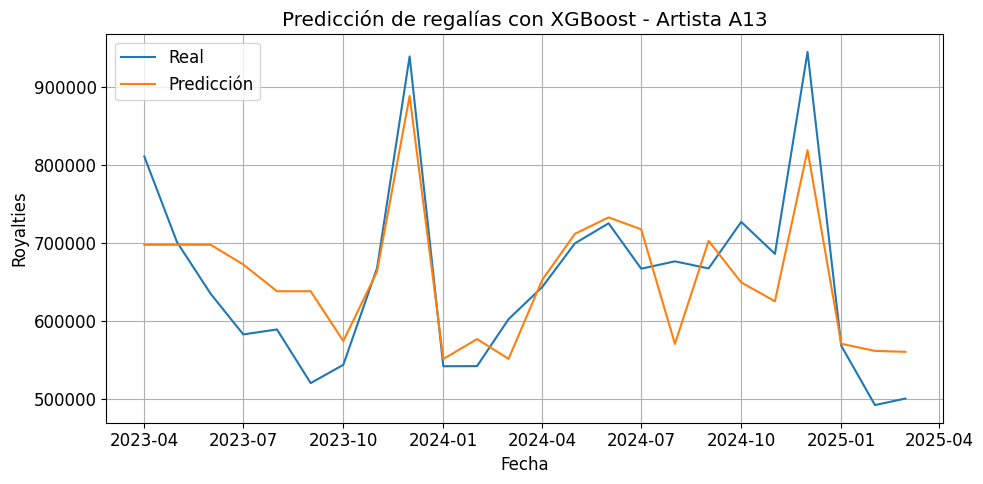

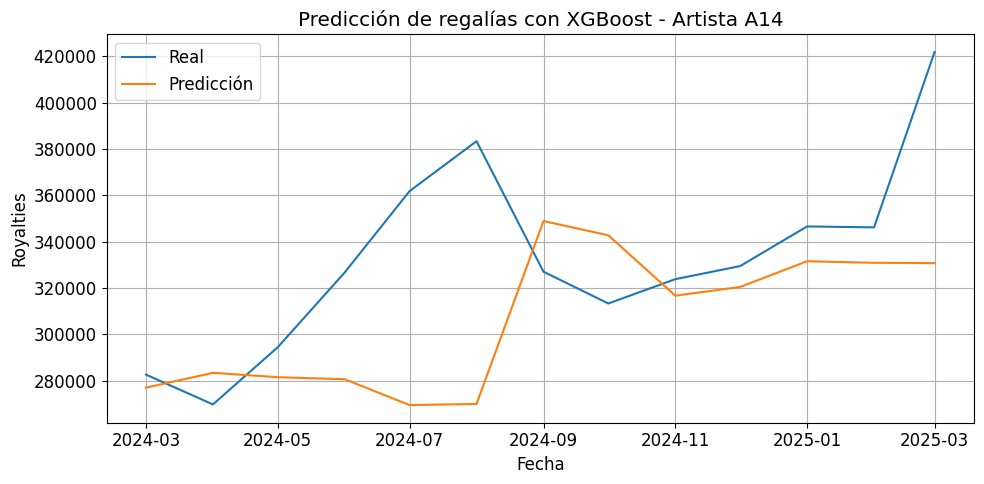

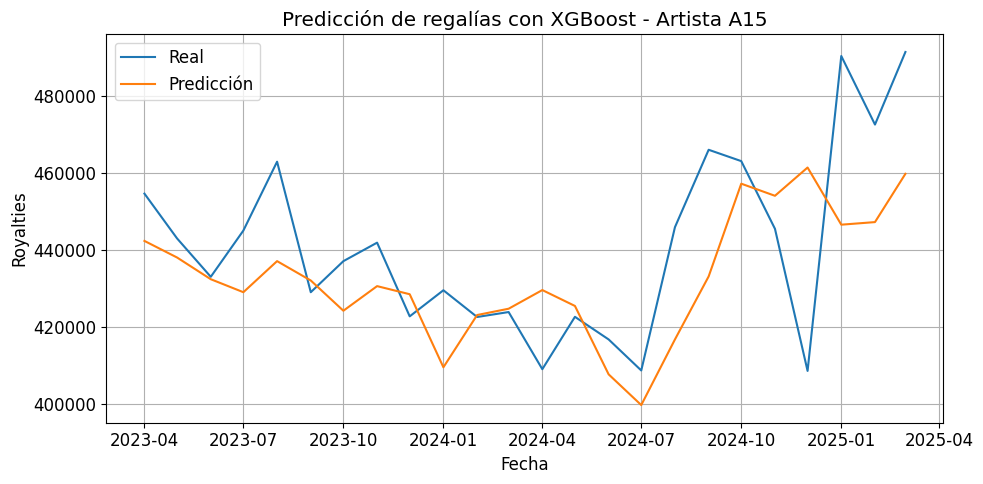

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar predicciones
df_predicciones_xgb = pd.read_csv("xgboost_predicciones_para_powerbi.csv")
df_predicciones_xgb['fecha'] = pd.to_datetime(df_predicciones_xgb['fecha'])

plt.rcParams.update({'font.size': 12})

for artist in df_predicciones_xgb["artist_id"].unique():
    subset = df_predicciones_xgb[df_predicciones_xgb["artist_id"] == artist]

    plt.figure(figsize=(10,5))
    plt.plot(subset["fecha"], subset["royalties_real"], label="Real")
    plt.plot(subset["fecha"], subset["royalties_pred"], label="Predicción")
    plt.title(f"Predicción de regalías con XGBoost - Artista {artist}")
    plt.xlabel("Fecha")
    plt.ylabel("Royalties")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Forecast

XGBoost no predice naturalmente en el tiempo futuro como Prophet o SARIMAX.
Se suele preparar de dos formas:

* Rolling Prediction: predecir 1 mes, agregarlo al dataset, volver a predecir el siguiente mes, etc.
* Batch Prediction: si tenés todas las variables independientes del futuro (por ejemplo, mes, año, sentimiento futuro, lanzamientos futuros), podrías predecir todo de golpe.
(pero normalmente no tenemos eso en real forecast).

En nuestro caso, lo que corresponde es hacer rolling:
1. Predecimos el primer mes usando el último dato disponible.
2. Ese primer forecast lo usamos como input para predecir el segundo mes.
3. Así sucesivamente hasta llegar a los 6 meses.

In [6]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# ================================================================
# 🏆 Hiperparámetros globales finales
# ================================================================
best_params = {
    "max_depth": 5,
    "learning_rate": 0.193,
    "subsample": 0.79,
    "colsample_bytree": 0.74,
    "n_estimators": 1000,
    "random_state": 42,
    "objective": "reg:squarederror"
}

# ================================================================
# ⚙️ Configuración general de gráficos
# ================================================================
plt.rcParams.update({'font.size': 12, 'figure.facecolor': 'white'})

# ---------------- helpers de formato ----------------
def _fmt_money(x):
    if x is None or not np.isfinite(x): return "—"
    if x >= 1e6:  return f"{x/1e6:,.2f} M"
    if x >= 1e3:  return f"{x/1e3:,.2f} k"
    return f"{x:,.0f}"

def _human_scale(max_val):
    if max_val >= 1e6: return 1e6, "Royalties (millones)"
    if max_val >= 1e3: return 1e3, "Royalties (miles)"
    return 1, "Royalties"

# ================================================================
# 1) CÁLCULO DEL FORECAST (sin graficar)
# ================================================================
def forecast_xgboost_por_artista(df, artist_id, steps=6):
    """
    Entrena XGBoost y realiza forecast rolling (+1% mensual en followers,
    track_release=0, month futuro). Devuelve un DataFrame con 6 filas.
    """
    df_artista = df[df['artist_id'] == artist_id].copy().sort_values('fecha')
    if df_artista.empty:
        raise ValueError(f"Sin datos para {artist_id}")

    df_artista['fecha'] = pd.to_datetime(df_artista['fecha'])
    df_artista = df_artista.set_index('fecha').asfreq('MS')

    features = [
        "instagram_followers", "twitter_followers", "track_release", "sentiment",
        "seguidores_menciones", "cant_posteos", "cant_comentarios",
        "mean_royalties_6m", "std_instagram_followers_6m",
        "growth_twitter_followers", "growth_instagram_followers",
        "sum_track_releases_6m", "mean_sentiment_3m",
        "sum_seguidores_menciones_3m", "month"
    ]

    df_artista['month'] = df_artista.index.month
    X = df_artista[features].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(method="bfill")
    y = pd.to_numeric(df_artista["royalties"], errors="coerce").fillna(method="ffill").fillna(method="bfill")

    modelo = XGBRegressor(**best_params)
    modelo.fit(X, y, eval_set=[(X, y)], eval_metric="rmse", early_stopping_rounds=50, verbose=False)

    forecasts = []
    last_date = df_artista.index[-1]
    last_features = X.iloc[-1].copy()

    for _ in range(steps):
        next_date = last_date + pd.DateOffset(months=1)
        f = last_features.copy()

        # +1% mensual en followers
        f["instagram_followers"] *= 1.01
        f["twitter_followers"]   *= 1.01

        # sin lanzamientos
        f["track_release"] = 0

        # mes futuro
        f["month"] = next_date.month

        y_pred = float(modelo.predict(pd.DataFrame([f]))[0])
        forecasts.append({"artist_id": artist_id, "fecha_prediccion": next_date, "royalties_forecast": y_pred})

        last_date = next_date
        last_features = f

    return pd.DataFrame(forecasts)

def calcular_forecasts_xgb(df, steps=6):
    """Devuelve (lista_forecasts, df_consolidado). No grafica nada."""
    lista_forecasts = []
    for artist_id in tqdm(df['artist_id'].unique(), desc="XGB forecasts"):
        try:
            lista_forecasts.append(forecast_xgboost_por_artista(df, artist_id, steps=steps))
        except Exception as e:
            print(f"⚠️ Error en {artist_id}: {e}")
    df_consolidado = pd.concat(lista_forecasts, ignore_index=True) if lista_forecasts else pd.DataFrame()
    return lista_forecasts, df_consolidado


# ================================================================
# USO
# ================================================================
# 1) calcular
lista_forecasts_xgb, df_forecasts_consolidado = calcular_forecasts_xgb(df, steps=6)

# (opcional) guardar los números, no las imágenes
df_forecasts_consolidado.to_csv("xgboost_forecast_royalties_artistas.csv", index=False)


XGB forecasts:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipython-input-1566834383.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df_artista[features].apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-1566834383.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = pd.to_numeric(df_artista["royalties"], errors="coerce").fillna(method="ffill").fillna(method="bfill")
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_roun

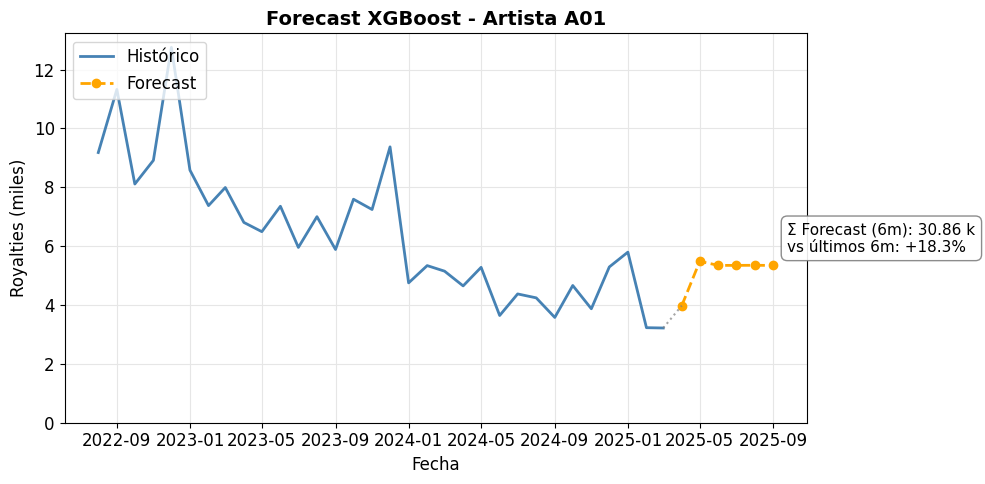

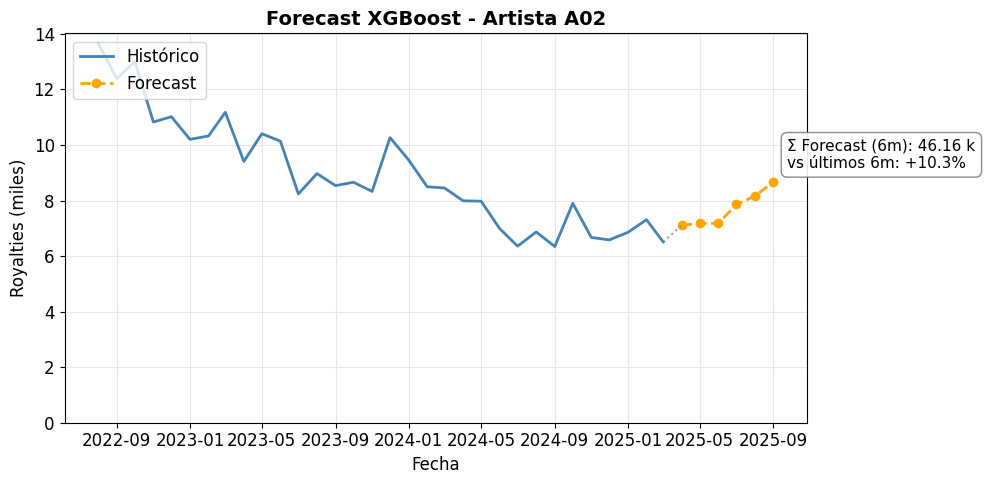

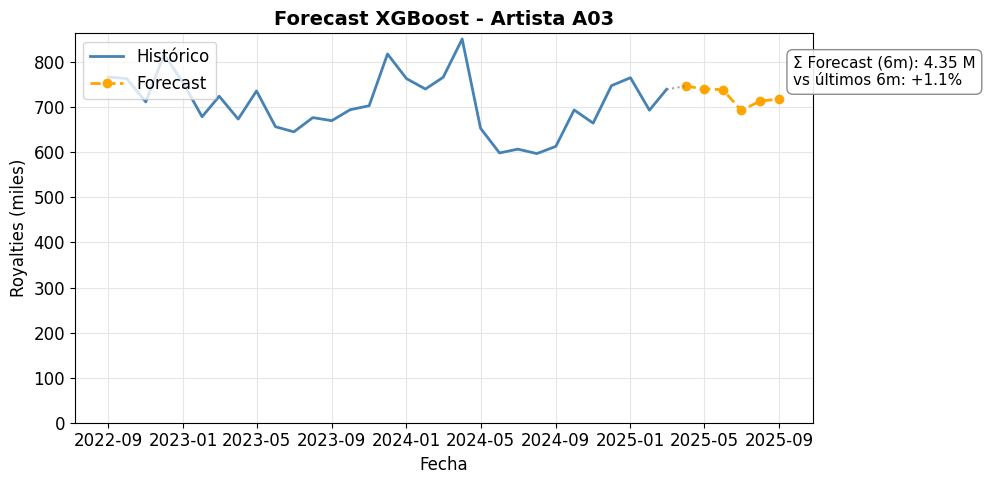

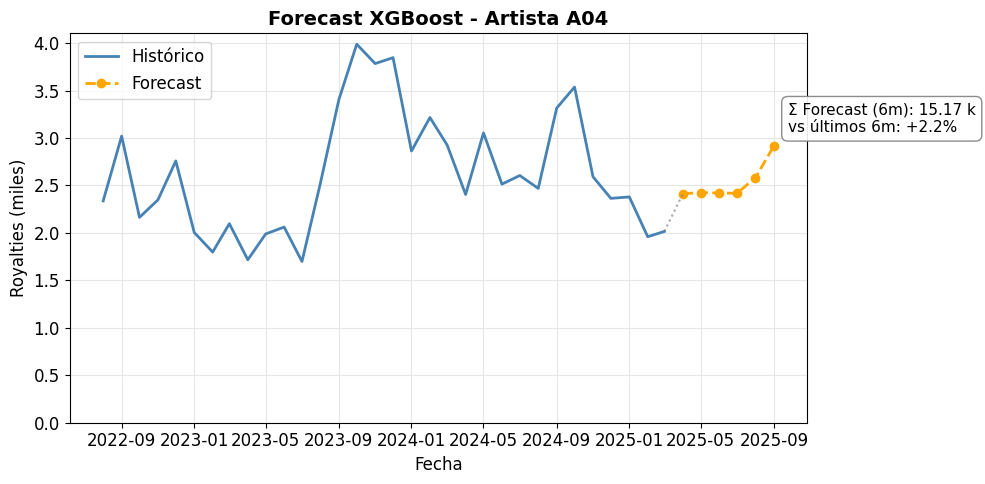

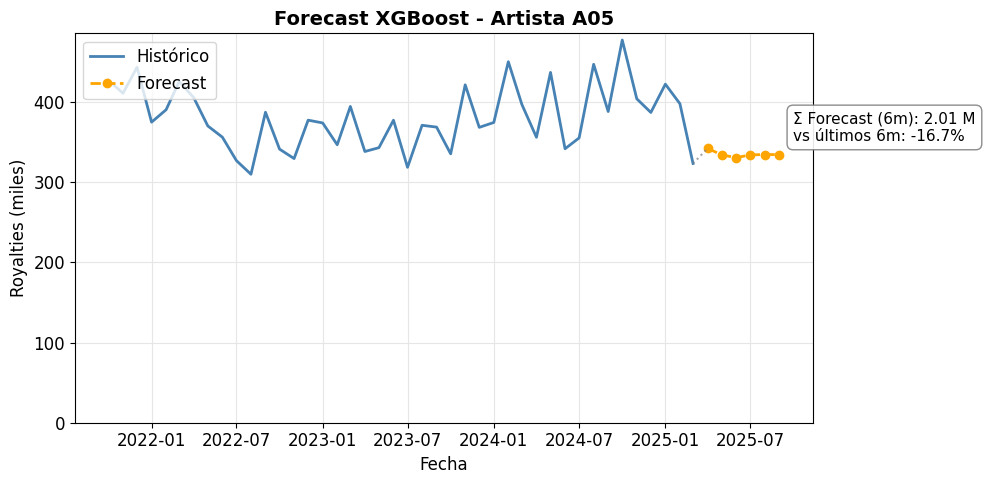

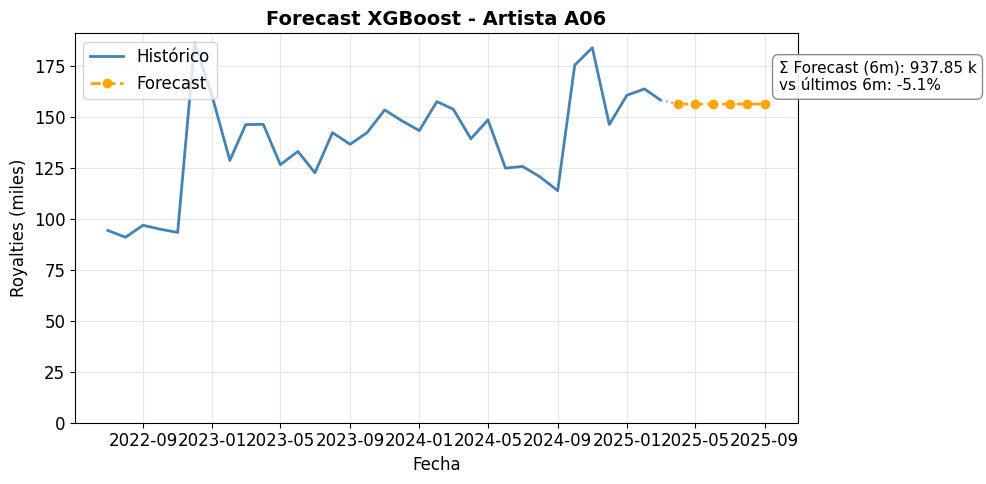

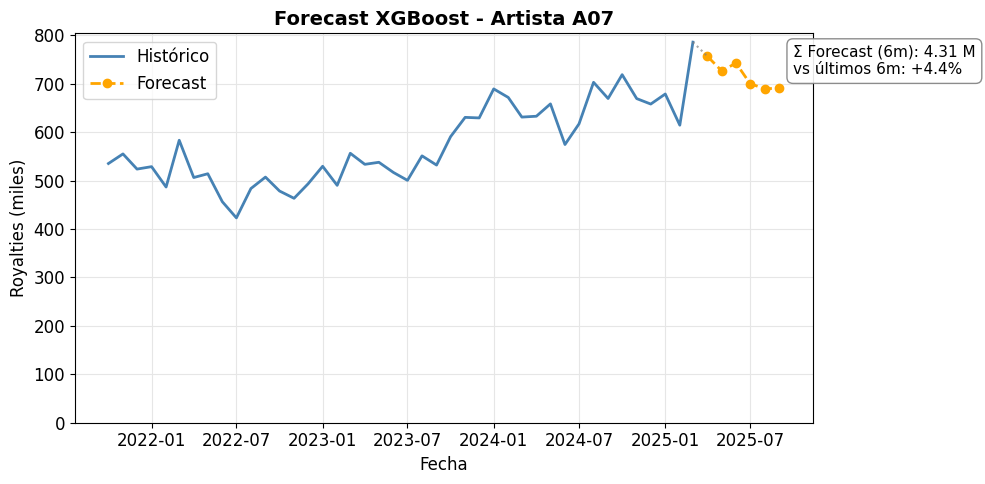

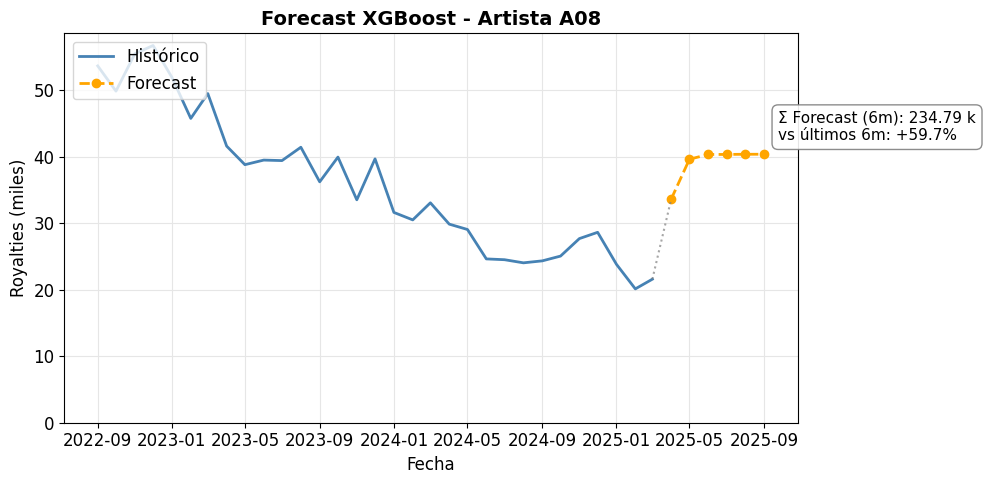

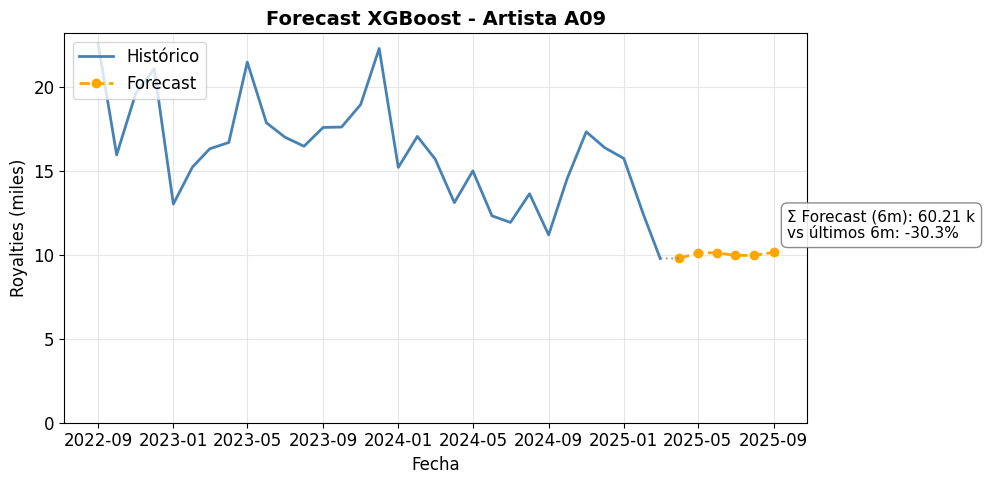

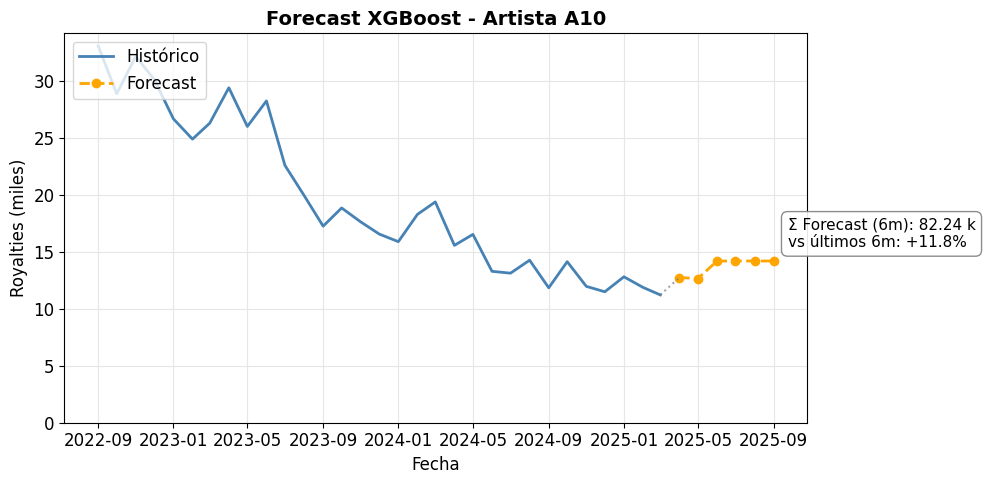

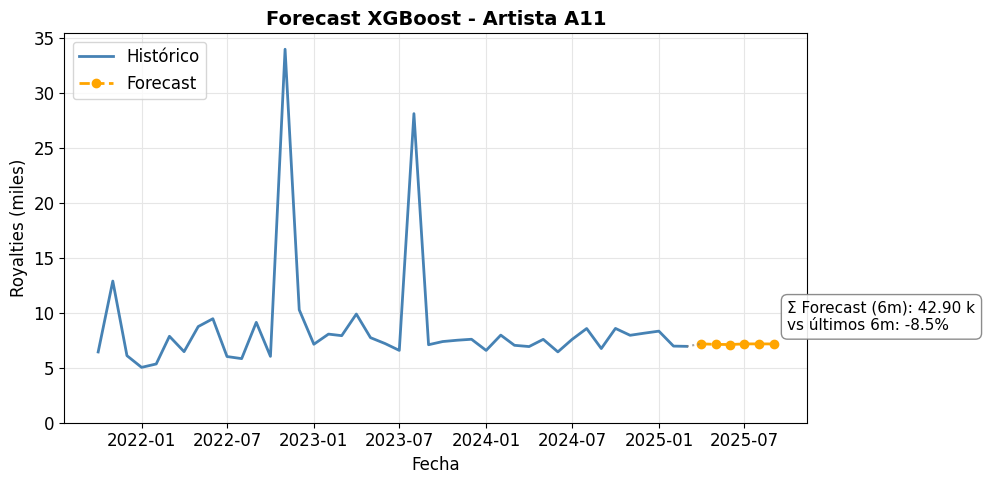

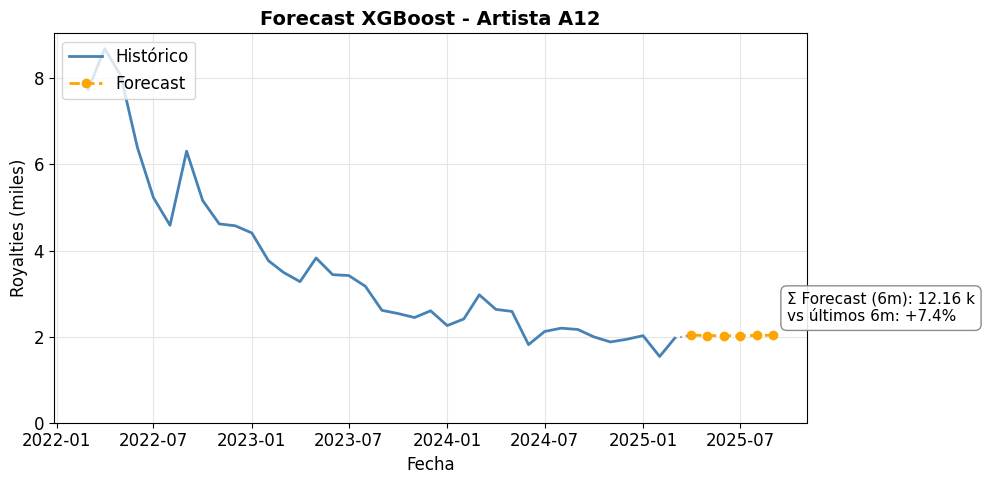

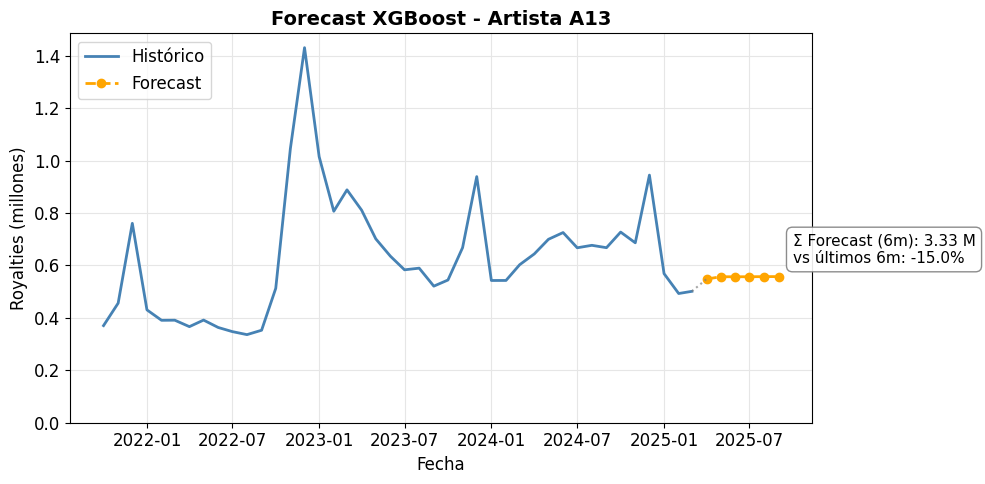

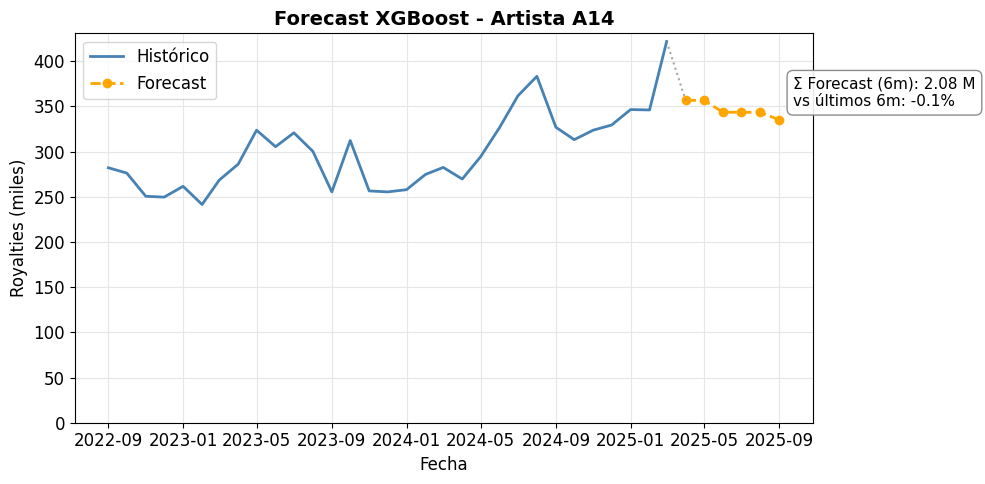

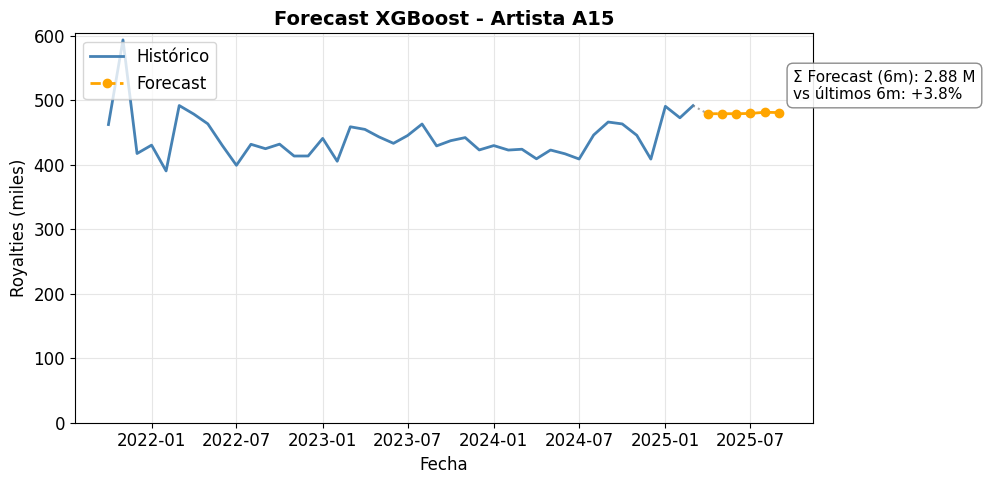

In [9]:
# ================================================================
# 2) GRÁFICOS (sin guardar) + Σ Forecast y vs últimos 6m
# ================================================================
def graficar_xgb(df_hist, lista_forecasts):
    """
    Muestra un gráfico por artista en pantalla, sin guardar.
    Añade:
      - Σ Forecast (6m)
      - vs últimos 6m históricos (%)
      - línea de unión último real → primer forecast
      (sin warnings de converter)
    """
    import matplotlib.pyplot as plt
    import numpy as np

    for fc in lista_forecasts:
        if fc.empty:
            continue

        artist_id = fc["artist_id"].iloc[0]
        g_hist = df_hist[df_hist["artist_id"] == artist_id].sort_values("fecha").copy()
        if g_hist.empty:
            continue

        # preparar series
        g_hist["fecha"] = pd.to_datetime(g_hist["fecha"])
        g_hist = g_hist.set_index("fecha").asfreq("MS")
        y = g_hist["royalties"]

        fc_plot = (fc.sort_values("fecha_prediccion")
                     .set_index("fecha_prediccion")["royalties_forecast"])

        # escala automática
        max_val = max(y.max(), fc_plot.max())
        scale, y_label = _human_scale(max_val)

        # convertir a objetos datetime de Python (evita el warning)
        x_hist = y.index.to_pydatetime()
        y_hist = (y/scale).values
        x_fc   = fc_plot.index.to_pydatetime()
        y_fc   = (fc_plot/scale).values

        fig, ax = plt.subplots(figsize=(10,5))

        # histórico (Matplotlib puro)
        ax.plot(x_hist, y_hist, label="Histórico", color="steelblue", linewidth=2)

        # forecast (Matplotlib puro)
        ax.plot(x_fc, y_fc, label="Forecast", color="orange",
                marker="o", linestyle="--", linewidth=2)

        # unión último real → primer forecast (Matplotlib puro)
        ax.plot([x_hist[-1], x_fc[0]], [y_hist[-1], y_fc[0]],
                color="gray", linestyle=":", alpha=0.7)

        # sumatorias
        yhat_sum = float(np.clip(fc_plot.values, 0, None).sum())
        last6_hist_sum = float(y.tail(6).sum()) if len(y) >= 6 else np.nan
        pct_vs_last6 = (yhat_sum / last6_hist_sum - 1.0) * 100.0 \
                       if np.isfinite(last6_hist_sum) and last6_hist_sum > 0 else np.nan

        resumen = f"Σ Forecast (6m): {_fmt_money(yhat_sum)}"
        if np.isfinite(pct_vs_last6):
            signo = "+" if pct_vs_last6 >= 0 else ""
            resumen += f"\nvs últimos 6m: {signo}{pct_vs_last6:.1f}%"

        ax.annotate(resumen, xy=(x_fc[-1], y_fc[-1]),
                    xytext=(10, 10), textcoords="offset points",
                    fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", alpha=0.9))

        ax.set_title(f"Forecast XGBoost - Artista {artist_id}", fontsize=14, fontweight="bold")
        ax.set_xlabel("Fecha"); ax.set_ylabel(y_label)
        ax.legend(loc="upper left")
        ax.set_ylim(bottom=0)
        ax.grid(True, which="both", color="#e6e6e6", linestyle="-", linewidth=0.8, alpha=1.0)
        plt.tight_layout()
        plt.show()


graficar_xgb(df, lista_forecasts_xgb)